![](https://mmbiz.qpic.cn/sz_mmbiz_jpg/gYUsOT36vfq8debSx7RJV8NahibXzTMAYP8yfNicjRqDibn7NfnqxvFicxibuIKxEm5QZeicwLLPlKKFiclUYg7Wx4lEQ/640?wx_fmt=jpeg&wxfrom=5&wx_lazy=1&wx_co=1)

# From: [超详细图解Self-Attention的那些事儿](https://mp.weixin.qq.com/s?__biz=MzI5MDUyMDIxNA==&mid=2247579430&idx=1&sn=3c63a42410e2107f1f91f861dc25c3cb&chksm=ec1d5adfdb6ad3c953722280aae160d9bf8a73d4cb4374de196d2a2b5bb2b53ac6b7eecbc568&mpshare=1&scene=1&srcid=05019UXsKNB17Qv7uzylnUDI&sharer_sharetime=1651341683033&sharer_shareid=d50902e5393c9beaed62a664f9b58b17#rd)

# 1. load package

In [74]:
import torch
from torch import nn
from math import sqrt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='darkgrid', font='SimHei')
print(torch.cuda.is_available())
cuda0 = torch.device('cuda:0')

True


In [61]:
# 字向量定义
X = torch.tensor([
    [1,2,1,2,1],
    [1,1,3,2,1],
    [3,1,2,1,1]
], dtype=torch.float64, device=cuda0)


# 2. $ Softmax(XX^T)X $

## 2.1 矩阵内积$ (XX^T) $的意义
* 求矩阵内每个字向量之间的相互投影，即相关程度

In [60]:
X_dot = X@X.T
X_dot

tensor([[11., 11., 10.],
        [11., 16., 13.],
        [10., 13., 16.]], device='cuda:0', dtype=torch.float64)

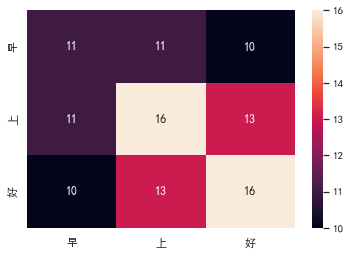

In [68]:
df_corr = pd.DataFrame(X_dot.cpu().T, columns=['早', '上', '好'], index=['早', '上', '好'])
ax = sns.heatmap(df_corr, annot=True)

## 2.2 $ Softmax() $的意义
![](https://mmbiz.qpic.cn/sz_mmbiz_jpg/gYUsOT36vfq8debSx7RJV8NahibXzTMAYfoTEVeRf6or6JibQ9KuG1kH4DblLQlxrsgKecEoxpkSUgj1d6kjpDBQ/640?wx_fmt=jpeg&wxfrom=5&wx_lazy=1&wx_co=1)
* 将进行归一化处理，转换成概率形式，使每一个字向量的和为1

In [76]:
# torch.matmul(X, X.T)
# torch.mm(X, X.T)
softmax = nn.Softmax(dim=-1)
sft_X_dot = softmax(X @ X.T)
sft_X_dot

tensor([[0.4223, 0.4223, 0.1554],
        [0.0064, 0.9465, 0.0471],
        [0.0024, 0.0473, 0.9503]], device='cuda:0', dtype=torch.float64)

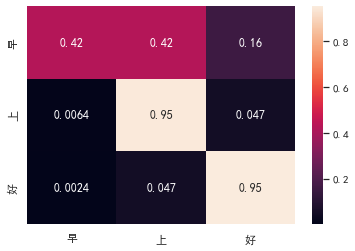

In [72]:
df_corr_weight = pd.DataFrame(sft_X_dot.cpu(), columns=['早', '上', '好'], index=['早', '上', '好'])
ax = sns.heatmap(df_corr_weight, annot=True)

## 2.3 最后一步$ Softmax(XX^T)X $的意义
![](https://mmbiz.qpic.cn/sz_mmbiz_jpg/gYUsOT36vfq8debSx7RJV8NahibXzTMAYNhw7lCUTCEpoUKNH2CEsGGqCPgNBQ1rkeYVI6cwzF4DYeX9ULXQMXA/640?wx_fmt=jpeg&wxfrom=5&wx_lazy=1&wx_co=1)
* 将“早”在每个字上的加权相关（即注意力）与原矩阵$X$的一个列向量相乘，求出一个新的行向量
* 在新的行向量中，每一个维度的数值都是由三个词向量在这一维度的数值加权求和得来的，这个新的行向量就是“早”字词向量经过注意力机制加权求和之后的表示

In [70]:
weight_sft_X_dot = sft_X_dot@X
weight_sft_X_dot

tensor([[1.3107, 1.4223, 2.0000, 1.8446, 1.0000],
        [1.0942, 1.0064, 2.9401, 1.9529, 1.0000],
        [2.9007, 1.0024, 2.0450, 1.0497, 1.0000]], device='cuda:0',
       dtype=torch.float64)

图中右半部分的颜色深浅，其实就是我们上图中黄色向量中数值的大小，意义就是单词之间的相关度（回想之前的内容，相关度其本质是由向量的内积度量的）！

![](https://mmbiz.qpic.cn/sz_mmbiz_jpg/gYUsOT36vfq8debSx7RJV8NahibXzTMAYawvlPOUnPibj0icbBKccm4A6iaC9QiaAbWtuXGhk3XVAz4AHttjhzUq4FA/640?wx_fmt=jpeg&wxfrom=5&wx_lazy=1&wx_co=1)

# 3. $QKV$矩阵
* [Transformer中K 、Q、V的设置以及为什么不能使用同一个值](https://www.cnblogs.com/jins-note/p/14508523.html)


![](https://mmbiz.qpic.cn/sz_mmbiz_jpg/gYUsOT36vfq8debSx7RJV8NahibXzTMAYZrGVNq0AaDiamGVwhTsENJgxJCzgpAkgQhnQibDvFOHWVnFrAUNgqiccg/640?wx_fmt=jpeg&wxfrom=5&wx_lazy=1&wx_co=1)

其实，许多文章中所谓的$QKV$矩阵、查询向量之类的字眼，根本其来源都是是$X$与矩阵的乘积，**本质上都是$X$的线性变换。**
* 为什么不直接使用$X$而要对其进行线性变换？
* 当然是为了提升模型的拟合能力，矩阵$W$都是可以训练的，起到一个缓冲的效果。
* 如果你真正读懂了前文的内容，读懂了$Softmax(XX^T)$这个矩阵的意义，相信你也理解了所谓查询向量一类字眼的含义。

## 3.1 $\sqrt d_k$的意义
* $d_k$为$K$的dimension
* $d$为$Softmax(QK^T)$的方差，
* $d$的值越大会导致$Softmax(QK^T)$的分布会趋于陡峭(分布的方差大，分布集中在绝对值大的区域)
* 控制$Softmax(QK^T)$的分布：
  * $Softmax(QK^T)$的分布会和$d$有关。$Softmax(QK^T)$中每一个元素除以$d$后，方差又变为1。
  * 利用$\sqrt d_k$对$Softmax(QK^T)$的分布“陡峭”程度与d解耦，从而使得训练过程中梯度值保持稳定
* 利用$Q$输入与key-value memories做检索，找到和问题相似的memory的key计算相关性分数，然后对value embedding进行加权求和，得到一个输出向量。衍生出了self-attention里的$Q$，$K$，$V$表示，在self-attention里的把X映射到$QKV$

# 4. Code